# Rescheduling mit Lateness (Summe)
> Planunghorizont Tag 0: 2 Tage <br>
> Rescheduling des Tages 1

In [12]:
# Datenzugriff
from configs.path_manager import get_path

# Utils
import src.utils.presenter as show
from src.utils.analize import check_constrains as check
from src.utils.production_process import initialize as init
from src.utils.production_process import filter as process_filter
from src.utils.production_process import gen_deadline as gen_deadline

# Solver Model
from src.models.lp import lateness_scheduling as lp_late_schedule
from src.models.lp import lateness_rescheduling as lp_late_reschedule
import src.models.heuristics.fcfs as fcfs

# Simulation
from src.simulation.ProductionSimulation import ProductionSimulation

# Extern
import pandas as pd
pd.set_option('display.max_rows', 16)

In [2]:
max_time = 60*6 # 6 min

In [3]:
# Datei laden
basic_data_path = get_path("data", "basic")
df_routings = pd.read_csv(basic_data_path / "instance.csv")
df_routings

df_jssp, df_jobs_arrivals = init.create_jobs_for_shifts(df_routings = df_routings,
                                                        routing_column = "Routing_ID", job_column = "Job",
                                                        shift_count = 1, shift_length = 1440,
                                                        u_b_mmax = 0.94, shuffle = True,
                                                        job_seed=40, arrival_seed=80
                                                       )
df_jobs_times = gen_deadline.get_times_df(df_jssp, df_jobs_arrivals, fcfs.schedule_with_arrivals, target_service=1.0)
df_jobs_times


Schedule-Informationen:
  Makespan: 2319


,Job,Routing_ID,Arrival,Ready Time,Deadline
0,J0,9,49,1440,1109.0
1,J1,5,130,1440,1104.0
2,J2,3,151,1440,1437.0
3,J3,4,226,1440,998.0
4,J4,6,386,1440,1203.0
...,...,...,...,...,...
15,J15,5,1142,1440,2116.0
16,J16,6,1254,1440,2071.0
17,J17,7,1285,1440,2343.0
18,J18,8,1397,1440,2569.0


## I) Complete Scheduling

In [4]:
# Scheduling
df_schedule = lp_late_schedule.solve_jssp_sum(df_jssp, df_jobs_times, solver= "HiGHS", msg=False, timeLimit=max_time, gapRel= 0.01)
df_schedule

BigM: 6000

Solver-Informationen:
  Summe absolute Lateness  : 69.0
  Solver-Status            : Optimal
  Anzahl Variablen         : 2140
  Anzahl Constraints       : 4040
  Laufzeit                 : ~135 Sekunden


,Job,Operation,Machine,Processing Time,Routing_ID,Arrival,Ready Time,Deadline,Start,End,Lateness,Absolute Lateness
0,J0,0,M01,85,9,49,1440,1109.0,49.0,134.0,-975.0,975.0
1,J0,1,M00,13,9,49,1440,1109.0,246.0,259.0,-850.0,850.0
2,J0,2,M02,61,9,49,1440,1109.0,259.0,320.0,-789.0,789.0
3,J0,3,M06,7,9,49,1440,1109.0,320.0,327.0,-782.0,782.0
4,J0,4,M08,64,9,49,1440,1109.0,327.0,391.0,-718.0,718.0
...,...,...,...,...,...,...,...,...,...,...,...,...
195,J19,5,M09,76,9,1398,1440,2458.0,2064.0,2140.0,-318.0,318.0
196,J19,6,M05,47,9,1398,1440,2458.0,2140.0,2187.0,-271.0,271.0
197,J19,7,M03,52,9,1398,1440,2458.0,2187.0,2239.0,-219.0,219.0
198,J19,8,M04,90,9,1398,1440,2458.0,2239.0,2329.0,-129.0,129.0


In [5]:
last_ops = df_schedule.sort_values(['Job', 'Operation']).drop_duplicates('Job', keep='last')
print(show.count_column_grouped(last_ops, 'Absolute Lateness'))

label
0            17
0 - 60        3
60 - 120      0
120 - 180     0
>180          0
Name: count, dtype: int64


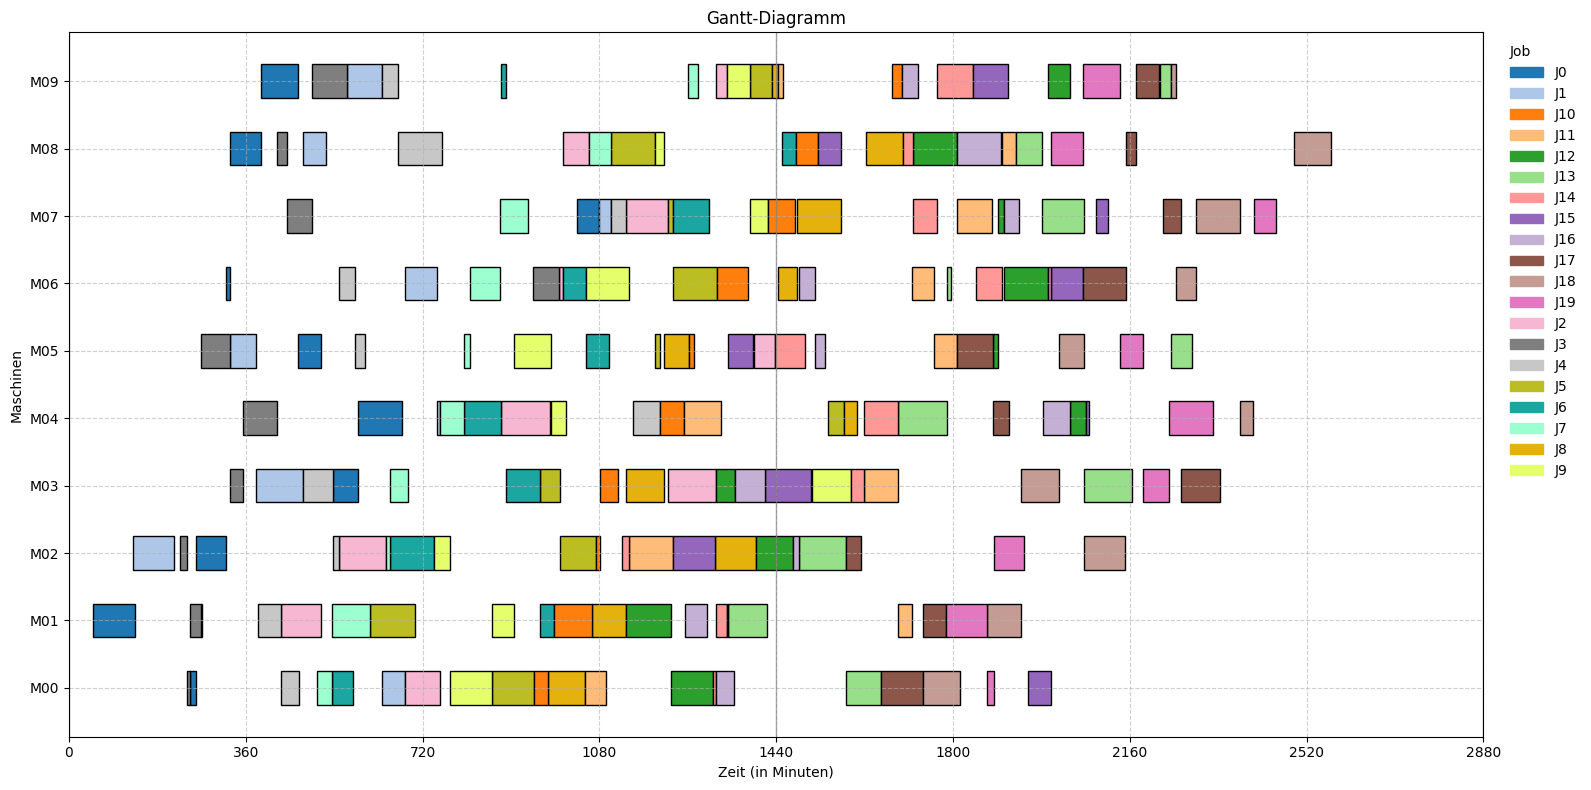

+ Keine Maschinenkonflikte gefunden
+ Alle Gruppen wurden in korrekter Operationsreihenfolge ausgeführt.
+ Alle technologischen Abhängigkeiten wurden eingehalten.
+ Alle Operation starten erst nach Arrival des Job


True

In [6]:
show.plot_gantt(df_schedule, perspective="Machine")
check.is_machine_conflict_free(df_schedule)
check.is_operation_sequence_correct(df_schedule)
check.is_job_timing_correct(df_schedule)
check.is_start_correct(df_schedule)

## II) Erster Tag (Tag 0)

### a) Simulation

In [7]:
day_length = 1440

In [8]:
day_numb = 0

day_start = day_length*day_numb 
day_end = day_start + day_length

In [10]:
simulation = ProductionSimulation(df_schedule, sigma=0.25)
df_execution = simulation.run(start_time = day_start, end_time=day_end)

[Day 0 00:49:00] Job J0 started on M01
[Day 0 02:10:00] Job J1 started on M02
[Day 0 02:19:41] Job J0 finished on M01 (after 90 minutes 42 seconds)
[Day 0 03:38:51] Job J1 finished on M02 (after 88 minutes 52 seconds)
[Day 0 03:46:00] Job J3 started on M02
[Day 0 04:04:40] Job J3 finished on M02 (after 18 minutes 40 seconds)
[Day 0 04:04:40] Job J3 started on M00
[Day 0 04:09:28] Job J3 finished on M00 (after 04 minutes 49 seconds)
[Day 0 04:09:28] Job J0 started on M00
[Day 0 04:09:28] Job J3 started on M01
[Day 0 04:19:12] Job J0 finished on M00 (after 09 minutes 43 seconds)
[Day 0 04:19:12] Job J0 started on M02
[Day 0 04:31:42] Job J3 finished on M01 (after 22 minutes 14 seconds)
[Day 0 04:31:42] Job J1 started on M01
[Day 0 04:31:42] Job J3 started on M05
[Day 0 04:34:34] Job J1 finished on M01 (after 02 minutes 52 seconds)
[Day 0 05:12:27] Job J0 finished on M02 (after 53 minutes 16 seconds)
[Day 0 05:20:00] Job J0 started on M06
[Day 0 05:28:54] Job J0 finished on M06 (after 08 

In [13]:
df_plan_undone = process_filter.get_unexecuted_operations(df_schedule, df_execution)
df_plan_undone 

,Job,Operation,Machine,Processing Time,Routing_ID,Arrival,Ready Time,Deadline,Start,End,Lateness,Absolute Lateness
0,J5,9,M04,33,2,464,1440,1579.0,1546.0,1579.0,0.0,0.0
1,J6,9,M08,30,1,480,1440,1481.0,1451.0,1481.0,0.0,0.0
2,J8,4,M02,85,8,526,1440,1698.0,1315.0,1400.0,-298.0,298.0
3,J8,5,M09,11,8,526,1440,1698.0,1432.0,1443.0,-255.0,255.0
4,J8,6,M06,40,8,526,1440,1698.0,1443.0,1483.0,-215.0,215.0
...,...,...,...,...,...,...,...,...,...,...,...,...
82,J19,5,M09,76,9,1398,1440,2458.0,2064.0,2140.0,-318.0,318.0
83,J19,6,M05,47,9,1398,1440,2458.0,2140.0,2187.0,-271.0,271.0
84,J19,7,M03,52,9,1398,1440,2458.0,2187.0,2239.0,-219.0,219.0
85,J19,8,M04,90,9,1398,1440,2458.0,2239.0,2329.0,-129.0,129.0


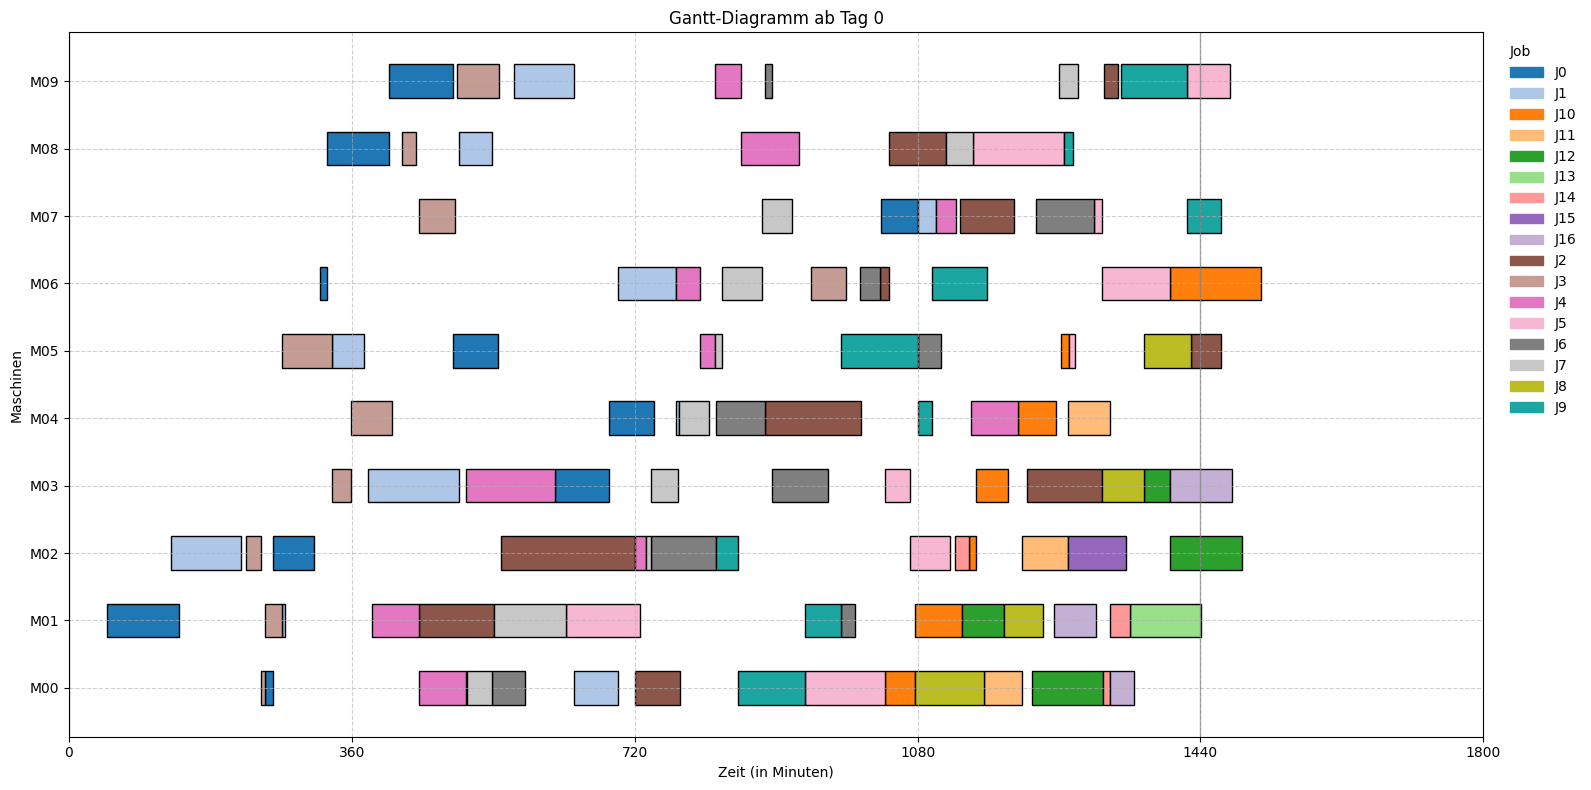

In [14]:
if not df_execution.empty:
    show.plot_gantt(df_execution, perspective="Machine", title=f"Gantt-Diagramm ab Tag {day_numb}")
else:
    print(f"Nothing executed on day {day_numb}")

### b) Verbleibene Jobs (Rest)

In [15]:
df_plan_undone 

,Job,Operation,Machine,Processing Time,Routing_ID,Arrival,Ready Time,Deadline,Start,End,Lateness,Absolute Lateness
0,J5,9,M04,33,2,464,1440,1579.0,1546.0,1579.0,0.0,0.0
1,J6,9,M08,30,1,480,1440,1481.0,1451.0,1481.0,0.0,0.0
2,J8,4,M02,85,8,526,1440,1698.0,1315.0,1400.0,-298.0,298.0
3,J8,5,M09,11,8,526,1440,1698.0,1432.0,1443.0,-255.0,255.0
4,J8,6,M06,40,8,526,1440,1698.0,1443.0,1483.0,-215.0,215.0
...,...,...,...,...,...,...,...,...,...,...,...,...
82,J19,5,M09,76,9,1398,1440,2458.0,2064.0,2140.0,-318.0,318.0
83,J19,6,M05,47,9,1398,1440,2458.0,2140.0,2187.0,-271.0,271.0
84,J19,7,M03,52,9,1398,1440,2458.0,2187.0,2239.0,-219.0,219.0
85,J19,8,M04,90,9,1398,1440,2458.0,2239.0,2329.0,-129.0,129.0


In [16]:
df_jobs_times_undone = process_filter.update_times_after_operation_changes(df_jobs_times, df_plan_undone)
df_jobs_times_undone

,Job,Routing_ID,Arrival,Ready Time,Deadline
0,J5,2,464,1440,1579.0
1,J6,1,480,1440,1481.0
2,J8,8,526,1440,1698.0
3,J9,7,535,1440,1593.0
4,J10,0,922,1440,1697.0
5,J11,1,928,1440,1929.0
6,J12,2,950,1440,2065.0
7,J13,3,1001,1440,2287.0
8,J14,4,1127,1440,1899.0
9,J15,5,1142,1440,2116.0


## III) Rescheduling
> vereinfacht, ohne neu Aufträge (nur der Rest)

In [17]:
# Reduktion der bereits ausgeführten Operationen auf die relevanten für die nächsten Tage
df_execution_important = df_execution[df_execution["End"] >= 1440]
df_execution_important

,Job,Routing_ID,Operation,Machine,Arrival,Start,Processing Time,End
26,J10,0,6,M06,922,1401.55,115.77,1517.32
33,J12,2,3,M02,950,1401.60,91.60,1493.20
34,J13,3,0,M01,1001,1350.10,91.09,1441.19
41,J16,6,2,M03,1254,1401.60,79.15,1480.75
51,J2,3,9,M05,151,1427.34,39.04,1466.38
80,J5,2,8,M09,464,1423.18,53.84,1477.02
112,J9,7,8,M07,535,1423.18,43.57,1466.75


In [18]:
df_reschedule = lp_late_reschedule.solve_jssp_sum_with_fixed_ops(df_plan_undone, df_jobs_times_undone,
                                                                 df_execution_important,
                                                                 reschedule_start = 1440,
                                                                 solver= "HiGHS", msg=False, timeLimit=max_time, gapRel= 0.0)
df_reschedule

BigM: 4000

Solver-Informationen:
  Summe absolute Lateness  : 191.4
  Solver-Status            : Optimal
  Anzahl Variablen         : 540
  Anzahl Constraints       : 979
  Laufzeit                 : ~5 Sekunden


,Job,Operation,Machine,Processing Time,Routing_ID,Arrival,Ready Time,Deadline,Start,End,Lateness,Absolute Lateness
0,J5,9,M04,33,2,464,1440,1579.0,1546.0,1579.0,0.0,0.0
1,J6,9,M08,30,1,480,1440,1481.0,1451.0,1481.0,0.0,0.0
2,J8,4,M02,85,8,526,1440,1698.0,1506.2,1591.2,0.0,0.0
3,J8,5,M09,11,8,526,1440,1698.0,1591.2,1602.2,0.0,0.0
4,J8,6,M06,40,8,526,1440,1698.0,1602.2,1642.2,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
82,J19,5,M09,76,9,1398,1440,2458.0,2052.2,2128.2,0.0,0.0
83,J19,6,M05,47,9,1398,1440,2458.0,2128.2,2175.2,0.0,0.0
84,J19,7,M03,52,9,1398,1440,2458.0,2212.0,2264.0,0.0,0.0
85,J19,8,M04,90,9,1398,1440,2458.0,2264.0,2354.0,0.0,0.0


In [19]:
last_ops = df_reschedule.sort_values(['Job', 'Operation']).drop_duplicates('Job', keep='last')
print(show.count_column_grouped(last_ops, 'Lateness'))

label
<-180           0
-180 - -120     0
-120 - -60      0
-60 - 0         0
0              11
0 - 60          2
60 - 120        0
120 - 180       1
>180            0
Name: count, dtype: int64


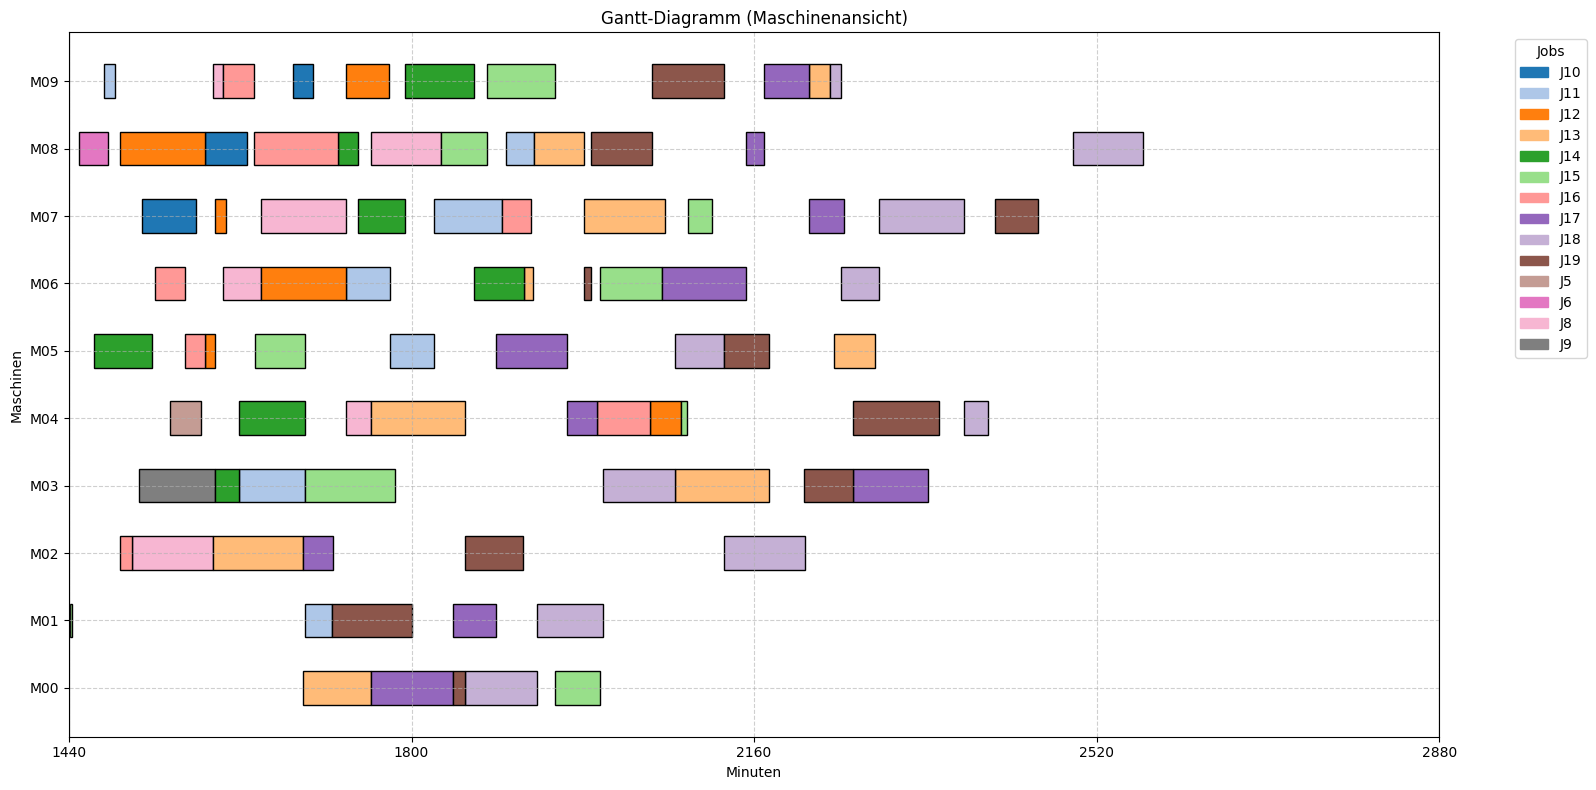

+ Keine Maschinenkonflikte gefunden
+ Alle Gruppen wurden in korrekter Operationsreihenfolge ausgeführt.
+ Alle technologischen Abhängigkeiten wurden eingehalten.
+ Alle Operation starten erst nach Arrival des Job


True

In [20]:
show.plot_gantt_machines(df_reschedule)
check.is_machine_conflict_free(df_reschedule)
check.is_operation_sequence_correct(df_reschedule)
check.is_job_timing_correct(df_reschedule)
check.is_start_correct(df_reschedule)

## Simulation + neuer Schedule 

In [21]:
df_combined = pd.concat([df_execution, df_reschedule], ignore_index=True)
df_combined

,Job,Routing_ID,Operation,Machine,Arrival,Start,Processing Time,End,Ready Time,Deadline,Lateness,Absolute Lateness
0,J0,9,0,M01,49,49.00,90.70,139.70,NaN,NaN,NaN,NaN
1,J0,9,1,M00,49,249.48,9.72,259.20,NaN,NaN,NaN,NaN
2,J0,9,2,M02,49,259.20,53.26,312.46,NaN,NaN,NaN,NaN
3,J0,9,3,M06,49,320.00,8.91,328.91,NaN,NaN,NaN,NaN
4,J0,9,4,M08,49,328.91,77.93,406.84,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
195,J19,9,5,M09,1398,2052.20,76.00,2128.20,1440.0,2458.0,0.0,0.0
196,J19,9,6,M05,1398,2128.20,47.00,2175.20,1440.0,2458.0,0.0,0.0
197,J19,9,7,M03,1398,2212.00,52.00,2264.00,1440.0,2458.0,0.0,0.0
198,J19,9,8,M04,1398,2264.00,90.00,2354.00,1440.0,2458.0,0.0,0.0


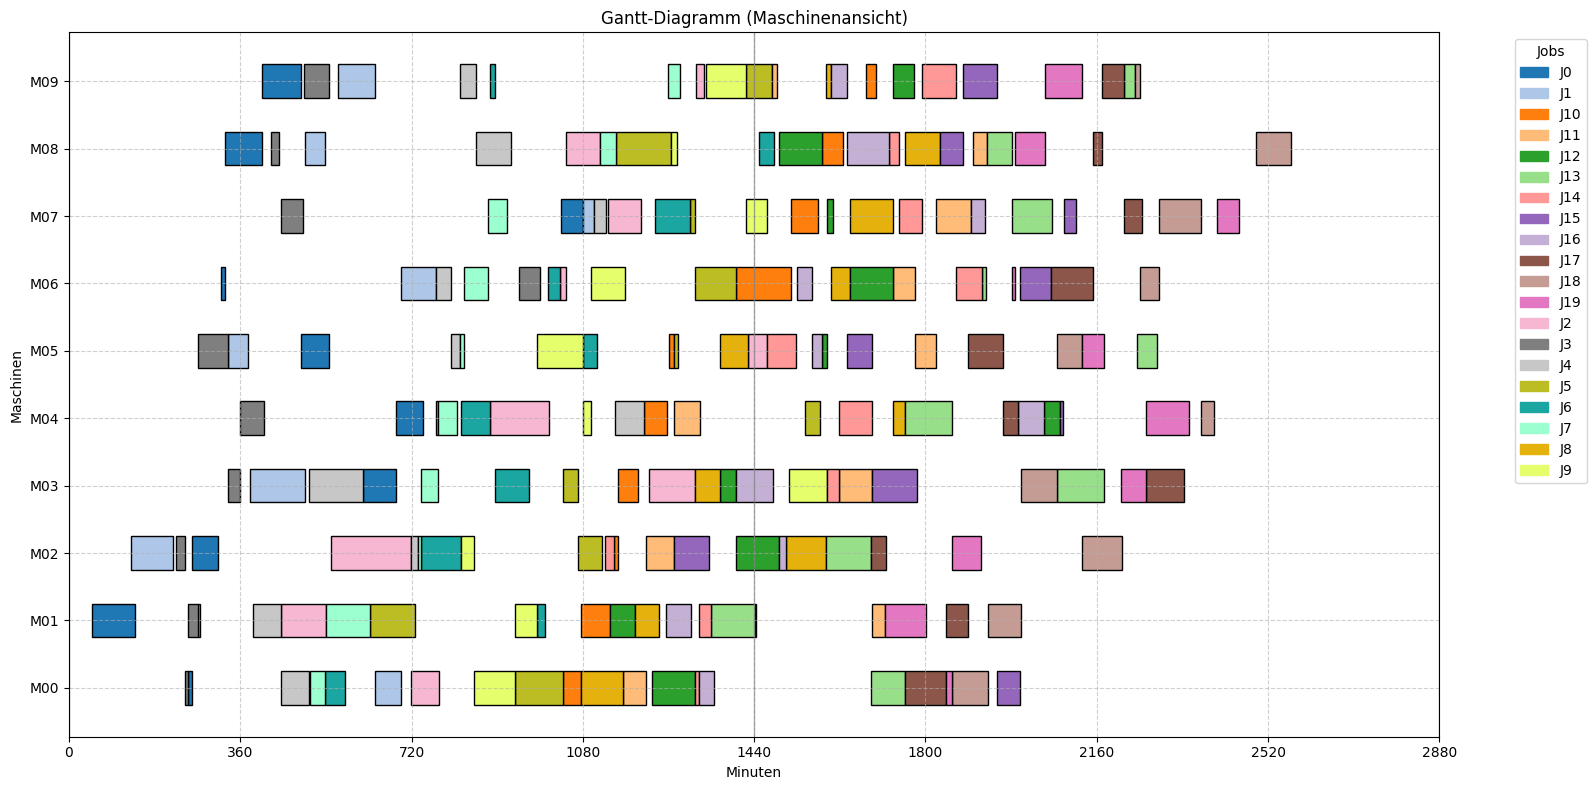

+ Keine Maschinenkonflikte gefunden
+ Alle Gruppen wurden in korrekter Operationsreihenfolge ausgeführt.
+ Alle technologischen Abhängigkeiten wurden eingehalten.
+ Alle Operation starten erst nach Arrival des Job


True

In [22]:
df = df_combined
show.plot_gantt_machines(df)
check.is_machine_conflict_free(df)
check.is_operation_sequence_correct(df)
check.is_job_timing_correct(df)
check.is_start_correct(df)